##### Это финальное задание по курсу «Поиск структуры в данных».

В нем вы попробуете визуализировать данные при помощи PCA и t-SNE и сравните визуально качество этих методов. Также вы попробуете использовать новые признаковые описания для повышения качества классификации объектов.

В качестве данных для этого задания будем использовать данные соревнования Otto Group Product Classification Challenge: https://www.kaggle.com/c/otto-group-product-classification-challenge

Так как данных там может быть слишком много для обработки на домашнем компьютере с помощью t-SNE, то мы сделали их случайную подвыборку и приложили к заданию (файл data.csv).

In [1]:
import matplotlib.pyplot as plt
import sklearn.ensemble
import sklearn.manifold
import sklearn.decomposition
import sklearn.metrics
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

### Загрузка данных

Загрузите данные из __data.csv__. Положите первые 70% объектов для обучения моделей, а оставшиеся 30% для контроля. Учтите, что первый столбец — это __id__ объекта и его нужно убрать из признаков (потому что сейчас классы объектов отсортированы по __id__). Так как некоторые алгоритмы и метрики считают, что метки классов — это последовательные числа с нуля, то сразу приведите целевую переменную к такому виду. Отрисовку и понижение размерности данных делайте сразу и для обучающей, и для тестовой выборки.

In [3]:
#cчитываем и смотрим статистику
data = pd.read_csv("data (2).csv")
data.describe()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,10000.000000,10000.000000,10000.0000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,30804.768600,0.418800,0.2591,0.894900,0.74830,0.073000,0.021500,0.189900,0.685500,0.965800,...,0.086000,0.530700,1.156300,0.389400,0.868200,0.474400,0.830600,0.237600,0.366400,0.128500
std,17906.587815,1.771361,1.2390,2.850555,2.51682,0.439875,0.180114,1.075525,2.333224,3.350456,...,1.322943,1.775154,2.925906,1.594309,2.069506,1.591916,4.793225,1.818592,0.965424,1.252815
min,5.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15062.250000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30589.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46367.250000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,61857.000000,61.000000,37.0000,37.000000,57.00000,11.000000,4.000000,38.000000,56.000000,43.000000,...,76.000000,41.000000,65.000000,60.000000,27.000000,59.000000,85.000000,39.000000,15.000000,54.000000


In [4]:
#убираем id
id_data=data['id']
data.drop(['id'], axis='columns', inplace=True)

In [5]:
#ищем NAN
data.isnull().sum().sum()

0

In [6]:
#выделяем целеыую переменную
y_str=data['target']
data.drop(['target'], axis='columns', inplace=True)

In [7]:
#преобразуем к числовому виду
import numpy as np
from sklearn import preprocessing

input_labels = list(set(y_str))
encoder = preprocessing.LabelEncoder()
encoder.fit(input_labels)
y = encoder.transform(y_str)
print("Encoded values =", list(y))


Encoded values = [1, 1, 1, 1, 1, 3, 7, 1, 6, 5, 6, 3, 1, 5, 7, 2, 0, 8, 2, 3, 1, 7, 3, 1, 5, 5, 3, 5, 1, 7, 1, 2, 2, 5, 3, 5, 3, 8, 1, 1, 2, 1, 7, 5, 5, 5, 1, 1, 2, 1, 6, 1, 5, 7, 7, 5, 6, 8, 1, 2, 8, 2, 5, 7, 5, 7, 5, 8, 1, 1, 1, 1, 4, 3, 7, 7, 5, 6, 3, 5, 2, 1, 7, 5, 1, 1, 7, 5, 7, 8, 1, 5, 1, 1, 6, 8, 5, 7, 1, 1, 1, 2, 8, 4, 1, 8, 8, 5, 5, 1, 7, 5, 7, 5, 5, 6, 8, 1, 1, 1, 1, 5, 1, 2, 0, 1, 6, 1, 6, 5, 1, 7, 1, 7, 5, 4, 8, 8, 7, 2, 1, 6, 7, 7, 1, 2, 5, 4, 5, 1, 4, 1, 5, 7, 6, 1, 5, 1, 6, 5, 3, 8, 2, 2, 1, 1, 7, 3, 1, 2, 5, 7, 1, 7, 2, 7, 1, 5, 3, 5, 7, 7, 7, 0, 8, 6, 2, 4, 6, 7, 8, 2, 8, 7, 7, 7, 1, 1, 7, 5, 5, 7, 5, 5, 4, 5, 3, 0, 1, 3, 8, 5, 8, 0, 3, 1, 5, 5, 1, 2, 2, 0, 7, 7, 1, 2, 7, 5, 5, 5, 1, 0, 1, 1, 7, 1, 5, 7, 5, 7, 2, 1, 7, 3, 1, 2, 5, 5, 7, 1, 2, 1, 7, 5, 7, 2, 1, 8, 5, 0, 1, 1, 5, 1, 5, 2, 6, 1, 2, 2, 6, 4, 2, 1, 7, 7, 7, 1, 2, 3, 1, 6, 7, 1, 5, 7, 0, 5, 0, 6, 5, 5, 1, 1, 1, 1, 8, 5, 1, 0, 1, 5, 2, 3, 5, 7, 7, 7, 2, 5, 3, 8, 5, 1, 1, 5, 7, 5, 8, 5, 8, 7, 1, 1, 5, 8, 5, 7

In [8]:
#делим на тест и трэйн
from sklearn import model_selection 
X=data
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X, y,  
                                                                                     test_size = 0.3)

### Визуализация с помощью PCA

Понизьте размерность данных до 2-ух с помощью метода главных компонент. Нарисуйте полученную выборку, при этом цветом выделите объекты разных классов.

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents=pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,-4.755285,1.014518
1,-4.507611,-2.075466
2,-3.519738,-3.222201
3,-4.735800,-1.457596
4,-3.656952,-2.436594
...,...,...
9995,-0.017373,-2.254922
9996,3.525743,4.586975
9997,0.880795,-0.553288
9998,-3.002022,10.533219


Text(0.5, 1.0, 'Метод главных компонент')

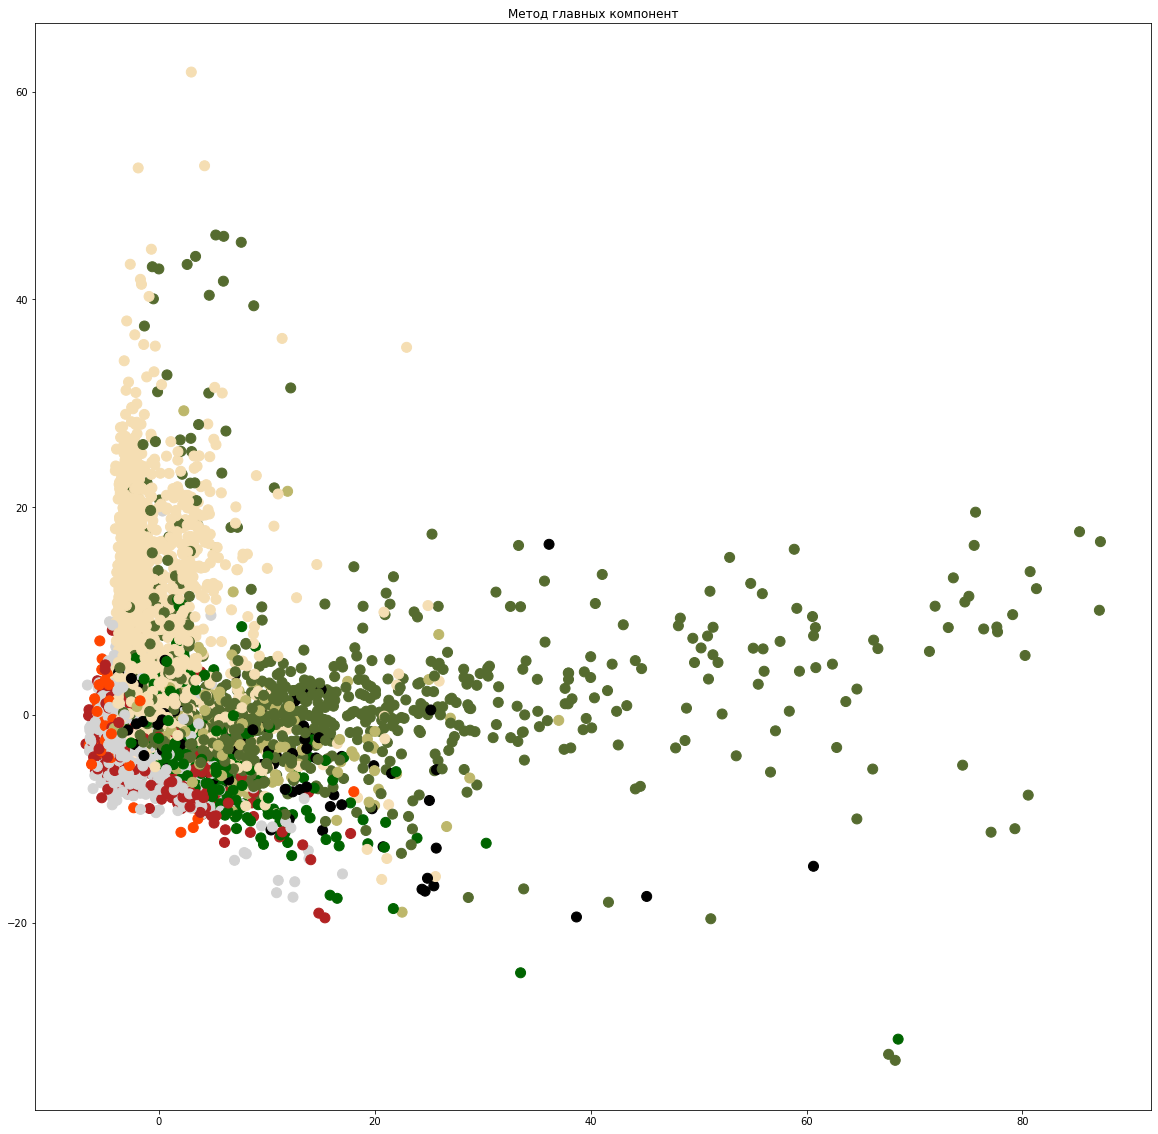

In [10]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
colors1=sorted_names[0:100:10]
c=pd.DataFrame(list(y))
for i in range(9):
    c[c==i]=colors1[i]
fig = plt.figure(figsize = (20, 20))
plt.scatter(principalDf['principal component 1'],principalDf['principal component 2'],c=[i.item() for i in c.to_numpy()],s=100)
plt.title("Метод главных компонент")

### Визуализация с помощью t-SNE

Теперь понизьте размерность данных до 2-ух с помощью метода t-SNE. В качестве параметров возьмите learning_rate=1000, init="random" и random_state=1234 (последнее — для воспроизводимости результата). Нарисуйте полученную выборку, при этом цветом выделите объекты разных классов. Сравните качественно разделимость классов при понижении размерности с помощью PCA и t-SNE.

In [11]:
from sklearn import manifold
tsne = manifold.TSNE(n_components = 2, learning_rate=1000, init="random", random_state = 1234)
data_2d_tsne = tsne.fit_transform(X)
data_2d_tsne

array([[ 16.47503  ,  75.41157  ],
       [  4.316265 ,  18.260122 ],
       [-11.791354 ,  36.121624 ],
       ...,
       [  2.1350617, -48.39978  ],
       [-66.437805 ,  26.035275 ],
       [ -1.053567 , -30.247154 ]], dtype=float32)

Text(0.5, 1.0, 'Метод t-SNE')

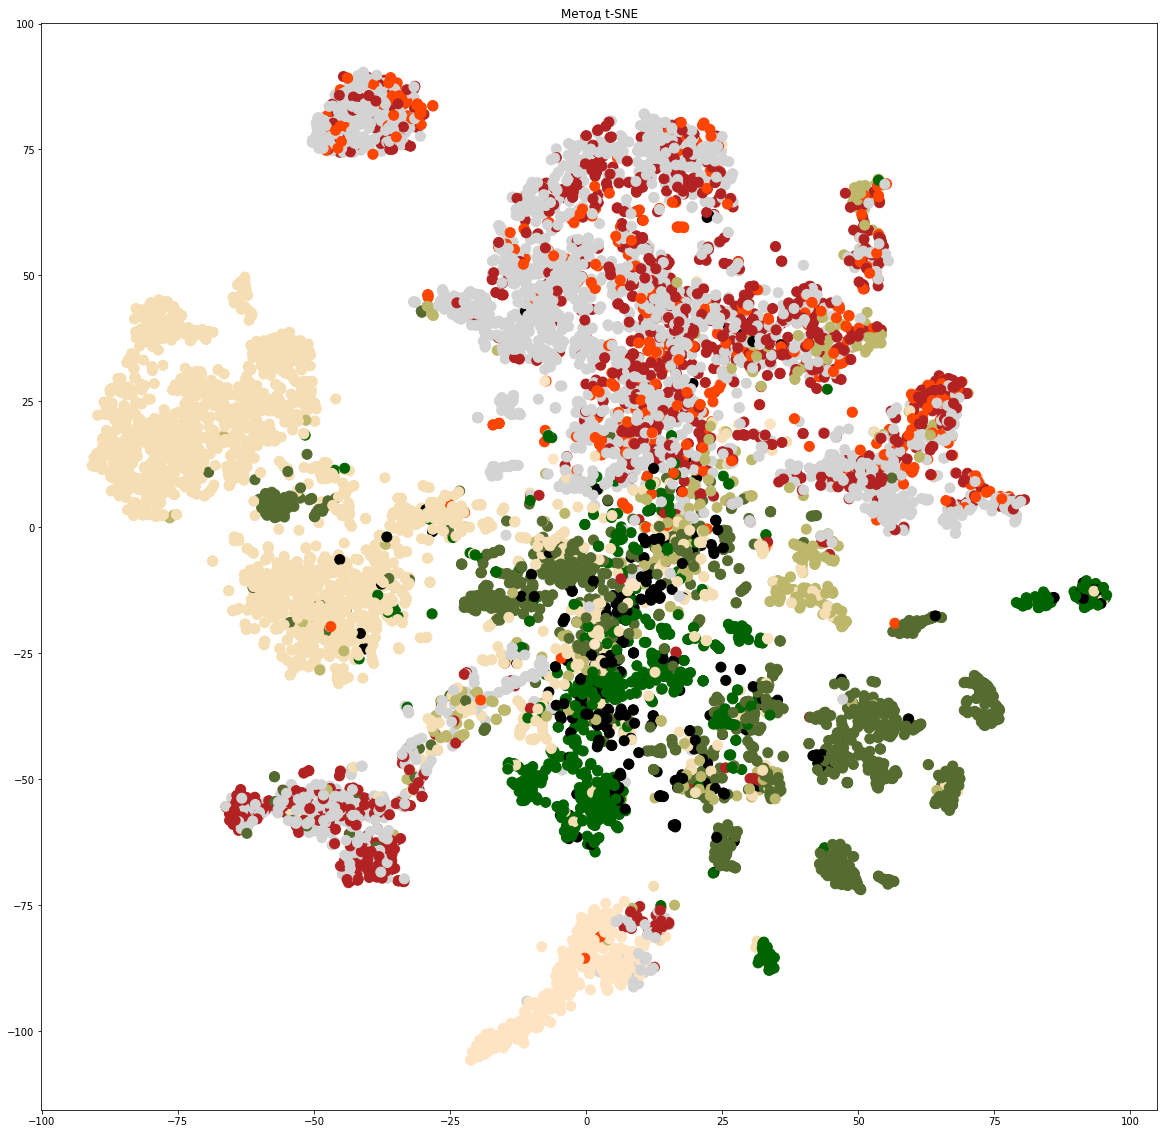

In [12]:
fig = plt.figure(figsize = (20, 20))
plt.scatter(data_2d_tsne[:,0],data_2d_tsne[:,1],c=[i.item() for i in c.to_numpy()],s=100)
plt.title("Метод t-SNE")

Метод t-sne работает лучше, визуально

### Обучение моделей

Обучите логистическую регрессию (linear_model.LogisticRegression) и случайный лес (ensemble.RandomForestClassifier) из sklearn. В первом случае подберите оптимальный параметр $C$ на отрезке $[10^{-4}, 10^{4}]$ (по степеням $10$ с шагом $1$, начиная с $-4$), а во втором при фиксированном числе деревьев в 50 подберите $max\_depth$ из отрезка $[2, 48]$ с шагом в 2. За целевую метрику качества возьмите мультиклассовый log-loss. В качестве схемы валидации используйте стратифицированную кросс-валидацию по 5-ти фолдам. Какие параметры оказались оптимальными? 

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import log_loss, make_scorer
log_loss_build =  metrics.make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True, labels=sorted(np.unique(y)))
param_grid={'C': [10**i for i in range(-4, 5,1)]}
optimizer = GridSearchCV(LogisticRegression(solver='liblinear'),param_grid,cv=5, scoring=log_loss_build)
param_grid_rf = {'max_depth':[i for i in range(2, 50,2)]}
optimizer_rf = GridSearchCV(ensemble.RandomForestClassifier(n_estimators = 50),param_grid_rf,cv=5, scoring=log_loss_build)
optimizer.fit(train_data, train_labels)
optimizer_rf.fit(train_data, train_labels)
print ('Лучшие параметры для модели LogisticRegression: {}'.format(optimizer.best_params_))
print ('Лучшие параметры для ансамбля RandomForestClassifier: {}'.format(optimizer_rf.best_params_))

C:\Users\User\Anaconda2\envs\p37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda2\envs\p37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda2\envs\p37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Лучшие параметры для модели LogisticRegression: {'C': 0.1}
Лучшие параметры для ансамбля RandomForestClassifier: {'max_depth': 22}


Посчитайте accuracy и log-loss на отложенной выборке для логистической регрессии и случайного леса. Какие они получились? Какой алгоритм лучше?

In [14]:
ylr_proba=optimizer.best_estimator_.predict_proba(test_data)
ylrf_proba=optimizer_rf.best_estimator_.predict_proba(test_data)

In [15]:
from sklearn.metrics import accuracy_score
print('Доля верных ответов согласно метрике accuracy для модели LogisticRegression: {} '.format(accuracy_score(test_labels,optimizer.best_estimator_.predict(test_data))))
print('Доля верных ответов согласно метрике accuracy для ансамбля RandomForestClassifier: {} '.format(accuracy_score(test_labels,optimizer_rf.best_estimator_.predict(test_data))))
print('Доля верных ответов согласно метрике log_loss для модели LogisticRegression: {} '.format(log_loss(test_labels,ylr_proba)))
print('Доля верных ответов согласно метрике log_loss для ансамбля RandomForestClassifier: {} '.format(log_loss(test_labels,ylrf_proba)))


Доля верных ответов согласно метрике accuracy для модели LogisticRegression: 0.7416666666666667 
Доля верных ответов согласно метрике accuracy для ансамбля RandomForestClassifier: 0.7536666666666667 
Доля верных ответов согласно метрике log_loss для модели LogisticRegression: 0.7329582280491956 
Доля верных ответов согласно метрике log_loss для ансамбля RandomForestClassifier: 0.7803644670689152 


RFclassifier лучше

### Использование PCA для улучшения классификации

Теперь попробуйте использовать PCA для улучшения качества классификации. Добавьте признаки из маломерного пространства (по 2 числа на каждый объект) в обучающую и тестовую выборку. Заново переподберите параметры к логистической регрессии и случайному лесу. Удалось ли таким образом улучшить качество моделей? Почему с теоретической точки зрения добавление признаков из PCA не должно улучшить качество логистической регрессии?

In [16]:
train_data.shape

(7000, 93)

In [21]:
for i in range(X.shape[0]):
    X.loc[i,'pca_1']=principalComponents[i,0]
    X.loc[i,'pca_2']=principalComponents[i,1]
X

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,pca_1,pca_2
0,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-4.755285,1.014518
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,-4.507611,-2.075466
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,-3.519738,-3.222201
3,0,0,1,0,1,0,0,0,0,2,...,9,0,8,3,0,0,0,0,-4.735800,-1.457596
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-3.656952,-2.436594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,-0.017373,-2.254922
9996,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.525743,4.586975
9997,0,0,3,1,0,0,0,13,1,0,...,0,0,1,3,0,0,0,0,0.880795,-0.553288
9998,0,1,2,2,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,-3.002022,10.533219


In [18]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X, y,  
                                                                                     test_size = 0.3)
param_grid={'C': [10**i for i in range(-4, 5,1)]}
optimizer = GridSearchCV(LogisticRegression(solver='liblinear'),param_grid,cv=5, scoring=log_loss_build)
param_grid_rf = {'max_depth':[i for i in range(2, 50,2)]}
optimizer_rf = GridSearchCV(ensemble.RandomForestClassifier(n_estimators = 50),param_grid_rf,cv=5, scoring=log_loss_build)
optimizer.fit(train_data, train_labels)
optimizer_rf.fit(train_data, train_labels)
print ('Лучшие параметры для модели LogisticRegression: {}'.format(optimizer.best_params_))
print ('Лучшие параметры для ансамбля RandomForestClassifier: {}'.format(optimizer_rf.best_params_))

C:\Users\User\Anaconda2\envs\p37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Лучшие параметры для модели LogisticRegression: {'C': 0.1}
Лучшие параметры для ансамбля RandomForestClassifier: {'max_depth': 20}


In [19]:
ylr_proba=optimizer.best_estimator_.predict_proba(test_data)
ylrf_proba=optimizer_rf.best_estimator_.predict_proba(test_data)
from sklearn.metrics import accuracy_score
print('Доля верных ответов согласно метрике accuracy для модели LogisticRegression: {} '.format(accuracy_score(test_labels,optimizer.best_estimator_.predict(test_data))))
print('Доля верных ответов согласно метрике accuracy для ансамбля RandomForestClassifier: {} '.format(accuracy_score(test_labels,optimizer_rf.best_estimator_.predict(test_data))))
print('Доля верных ответов согласно метрике log_loss для модели LogisticRegression: {} '.format(log_loss(test_labels,ylr_proba)))
print('Доля верных ответов согласно метрике log_loss для ансамбля RandomForestClassifier: {} '.format(log_loss(test_labels,ylrf_proba)))


Доля верных ответов согласно метрике accuracy для модели LogisticRegression: 0.7356666666666667 
Доля верных ответов согласно метрике accuracy для ансамбля RandomForestClassifier: 0.7426666666666667 
Доля верных ответов согласно метрике log_loss для модели LogisticRegression: 0.7384623346131713 
Доля верных ответов согласно метрике log_loss для ансамбля RandomForestClassifier: 0.779793083477945 


не улучшилось, потому что главные компоненты кореллируют с другими признаками

### Использование t-SNE для улучшения классификации

Теперь проделайте тоже самое с признаками из t-SNE. Стало ли лучше (относительно оригинальных признаков)?

In [22]:
X=data
for i in range(X.shape[0]):
    X.loc[i,'tsne_1']=data_2d_tsne[i,0]
    X.loc[i,'tsne_2']=data_2d_tsne[i,1]

In [26]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X, y,  
                                                                                     test_size = 0.3)
param_grid={'C': [10**i for i in range(-4, 5,1)]}
optimizer = GridSearchCV(LogisticRegression(solver='liblinear'),param_grid,cv=5, scoring=log_loss_build)
param_grid_rf = {'max_depth':[i for i in range(2, 50,2)]}
optimizer_rf = GridSearchCV(ensemble.RandomForestClassifier(n_estimators = 50),param_grid_rf,cv=5, scoring=log_loss_build)
optimizer.fit(train_data, train_labels)
optimizer_rf.fit(train_data, train_labels)
print ('Лучшие параметры для модели LogisticRegression: {}'.format(optimizer.best_params_))
print ('Лучшие параметры для ансамбля RandomForestClassifier: {}'.format(optimizer_rf.best_params_))

C:\Users\User\Anaconda2\envs\p37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda2\envs\p37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda2\envs\p37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda2\envs\p37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Лучшие параметры для модели LogisticRegression: {'C': 0.1}
Лучшие параметры для ансамбля RandomForestClassifier: {'max_depth': 18}


In [27]:
ylr_proba=optimizer.best_estimator_.predict_proba(test_data)
ylrf_proba=optimizer_rf.best_estimator_.predict_proba(test_data)
from sklearn.metrics import accuracy_score
print('Доля верных ответов согласно метрике accuracy для модели LogisticRegression: {} '.format(accuracy_score(test_labels,optimizer.best_estimator_.predict(test_data))))
print('Доля верных ответов согласно метрике accuracy для ансамбля RandomForestClassifier: {} '.format(accuracy_score(test_labels,optimizer_rf.best_estimator_.predict(test_data))))
print('Доля верных ответов согласно метрике log_loss для модели LogisticRegression: {} '.format(log_loss(test_labels,ylr_proba)))
print('Доля верных ответов согласно метрике log_loss для ансамбля RandomForestClassifier: {} '.format(log_loss(test_labels,ylrf_proba)))


Доля верных ответов согласно метрике accuracy для модели LogisticRegression: 0.7473333333333333 
Доля верных ответов согласно метрике accuracy для ансамбля RandomForestClassifier: 0.7716666666666666 
Доля верных ответов согласно метрике log_loss для модели LogisticRegression: 0.68417052504755 
Доля верных ответов согласно метрике log_loss для ансамбля RandomForestClassifier: 0.6987518704737389 


не стало, или я что-то делаю не так